## This notebook contains the code we used to test our classifier and generate data for the report. Please note that due to random data shuffling and random data generation, the tables and figures may not match the report exactly.

In [1]:
# set up packages
import cvxpy as cp
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils import shuffle
from MyClassifier_18 import MyClassifier
from tqdm import tqdm
import time
import matplotlib
from random import sample

## Part 1 - MNIST data

In [2]:
df_train = pd.read_csv('mnist_train.csv')
df_test = pd.read_csv('mnist_test.csv')

def data_loader(df_train,df_test,class_a,class_b,shuffle=False):

    # Only include points labeled 1 (a) or 7 (b)
    df_filtered_train = df_train.drop(df_train[(df_train['label'] != class_a)  & (df_train['label'] != class_b)].index)
    S = (df_filtered_train['label']).to_numpy()  # Seperate the labels from the data points
    S = np.reshape(S,(S.shape[0],1))
    Y = (df_filtered_train.drop('label', axis=1)).to_numpy()  

    if shuffle:
        Y,S = shuffle(Y, S, random_state=25)

    # Only include points labeled 1 (a) or 7 (b)
    df_filtered_test = df_test.drop(df_test[(df_test['label'] != class_a)  & (df_test['label'] != class_b)].index)
    S_test = (df_filtered_test['label']).to_numpy()
    S_test = np.reshape(S_test,(S_test.shape[0],1))

    # S_test = np.where(S_test==class_b, 1, -1)
    Y_test = (df_filtered_test.drop('label', axis=1)).to_numpy()

    return Y,S,Y_test,S_test

In [3]:
# Get the train and test data from the loader
Y,S,Y_test,S_test = data_loader(df_train,df_test,1,7)

In [4]:
# Training and checking the accuracy scores for entire dataset (no selective sampling)
lc = MyClassifier()
lc.train(Y,S)

In [5]:
print('Test accuracy after training on {} points is '.format(lc.num_queries)+str(lc.accuracy(Y_test,S_test)))

Test accuracy after training on 13007 points is 0.9856680536292187


In [6]:
# Now let's make use of selective sampling to train the data and check the results
lc_sample_selection = MyClassifier()

# Getting two points from the dataset that belong to each of the classes
uni = np.unique(S).tolist()
label_list = S.T.tolist()[0]
uni_ind = [label_list.index(uni[0]),label_list.index(uni[1])]
k = max(uni_ind)+1

# Adding these two points to the train set
lc_sample_selection.training_set_data = Y[uni_ind,:]
lc_sample_selection.training_set_labels = S[uni_ind,:]

# Training on the two points initially
lc_sample_selection.train(lc_sample_selection.training_set_data,lc_sample_selection.training_set_labels)
prev_num_queries = 0

for i in range(k,Y.shape[0]):
    prev_num_queries = lc_sample_selection.num_queries
    lc_sample_selection.sample_selection(Y[i,:],S[i])
    if(lc_sample_selection.num_queries > prev_num_queries):
        lc_sample_selection.training_set_labels = lc_sample_selection.training_set_labels.reshape(lc_sample_selection.training_set_labels.shape[0],1)
        lc_sample_selection.train(lc_sample_selection.training_set_data,lc_sample_selection.training_set_labels)

In [7]:
weights_ = np.squeeze(lc_sample_selection.weights)
np.savetxt("weights_18.csv", weights_, delimiter=",")
bias_ = lc_sample_selection.biases
np.savetxt("bias_18.csv", bias_, delimiter=",")

In [8]:
print('Test accuracy after training on {} points obtained using our selective sampling approach is '.format(lc_sample_selection.num_queries)+str(lc_sample_selection.accuracy(Y_test,S_test)))

Test accuracy after training on 37 points obtained using our selective sampling approach is 0.9852057327785483


In [9]:
# Experiments leading to delta = 0.04 selection

del_vals = np.linspace(0.001,0.35,num=100)
time_log = []
acc_vals = []
que_log = []
for val_delta in tqdm(del_vals):
    start_time = time.time()
    lc_sample_selection = MyClassifier()
    lc_sample_selection.delta = val_delta
    uni = np.unique(S).tolist()
    label_list = S.T.tolist()[0]
    uni_ind = [label_list.index(uni[0]),label_list.index(uni[1])]
    k = max(uni_ind)+1
    lc_sample_selection.training_set_data = Y[uni_ind,:]
    lc_sample_selection.training_set_labels = S[uni_ind,:]

    lc_sample_selection.train(lc_sample_selection.training_set_data,lc_sample_selection.training_set_labels)
    prev_num_queries = 0

    for i in range(k,Y.shape[0]):
        prev_num_queries = lc_sample_selection.num_queries
        lc_sample_selection.sample_selection(Y[i,:],S[i])
        if(lc_sample_selection.num_queries > prev_num_queries):
            lc_sample_selection.training_set_labels = lc_sample_selection.training_set_labels.reshape(lc_sample_selection.training_set_labels.shape[0],1)
            lc_sample_selection.train(lc_sample_selection.training_set_data,lc_sample_selection.training_set_labels)
    acc_vals.append(lc_sample_selection.accuracy(Y_test, S_test))
    time_log.append(time.time()-start_time)
    que_log.append(lc_sample_selection.num_queries)

100%|██████████| 100/100 [05:39<00:00,  3.39s/it]


In [10]:
# Normalizing these values for seeing the trend in delta correlation with the performance improvement
que_arr = np.array(que_log)
que_arr = (que_arr - np.min(que_arr))/(np.max(que_arr)-np.min(que_arr))
time_arr = np.array(time_log)
time_arr = (time_arr - np.min(time_arr))/(np.max(time_arr)-np.min(time_arr))
acc_arr = np.array(acc_vals)
acc_arr = (acc_arr - np.min(acc_arr))/(np.max(acc_arr)-np.min(acc_arr))

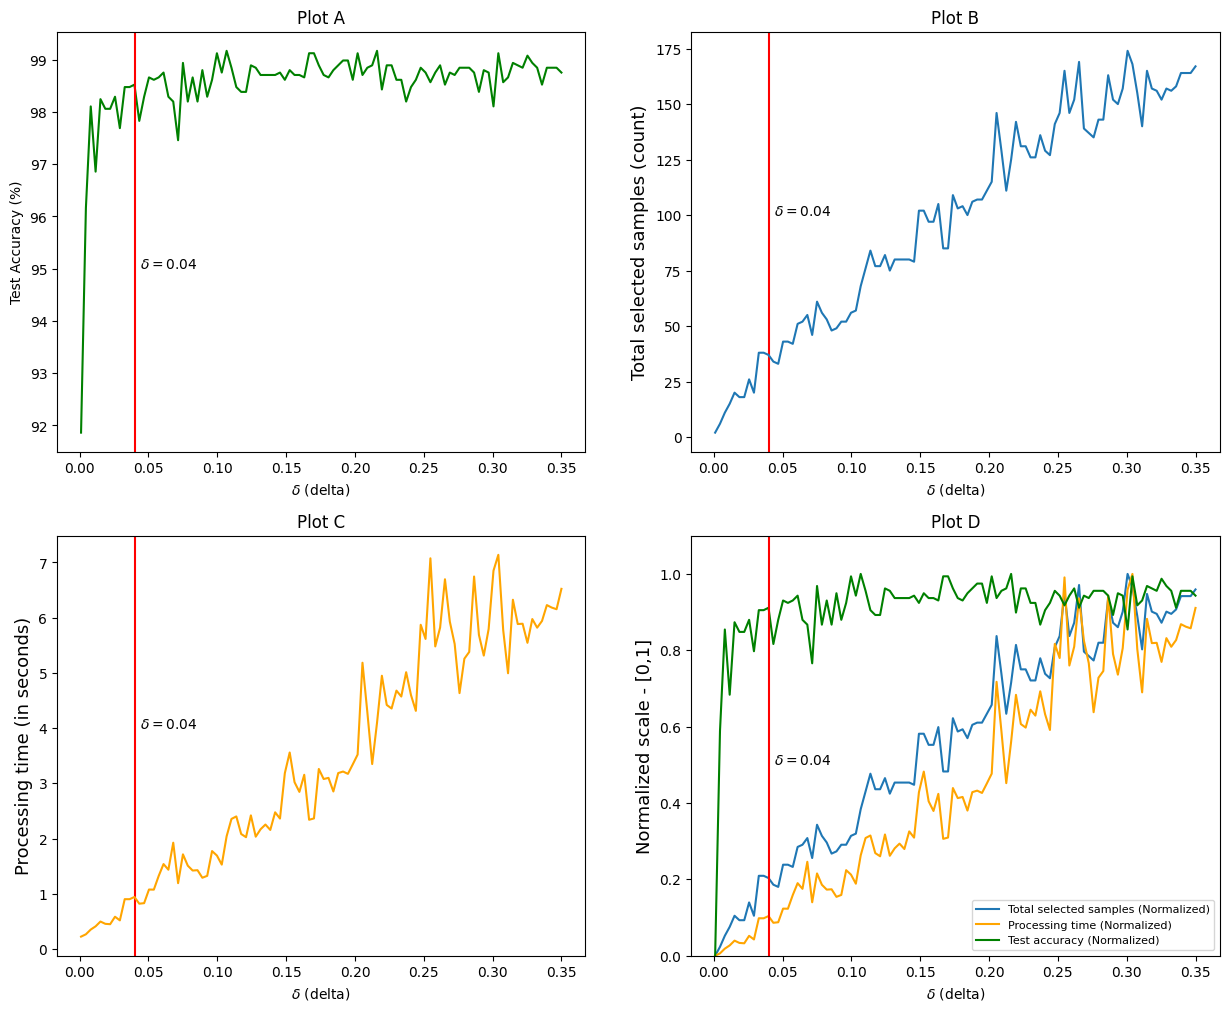

In [11]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

fig, axs = plt.subplots(2, 2,figsize=(15,12))
axs[0,0].set_xlabel('$\delta$ (delta)')
axs[0,1].set_xlabel('$\delta$ (delta)')
axs[1,0].set_xlabel('$\delta$ (delta)')
axs[1,1].set_xlabel('$\delta$ (delta)')
axs[0,0].set_ylabel('Test Accuracy (%)')
axs[0,1].set_ylabel('Total selected samples (count)',fontsize=13)
axs[1,0].set_ylabel('Processing time (in seconds)',fontsize=13)
axs[1,1].set_ylabel('Normalized scale - [0,1]',fontsize=13)
axs[0,0].set_title('Plot A')
axs[0,1].set_title('Plot B')
axs[1,0].set_title('Plot C')
axs[1,1].set_title('Plot D')
axs[0,0].plot(del_vals,np.multiply(100,acc_vals),'g')
axs[0,0].axvline(x=0.04,color='r')
axs[0,1].axvline(x=0.04,color='r')
axs[1,0].axvline(x=0.04,color='r')
axs[0,0].text(0.044,95,'$\delta = 0.04$',horizontalalignment='left')
axs[0,1].text(0.044,100,'$\delta = 0.04$',horizontalalignment='left')
axs[1,0].text(0.044,4,'$\delta = 0.04$',horizontalalignment='left')
axs[1,1].text(0.044,0.5,'$\delta = 0.04$',horizontalalignment='left')
axs[0,1].plot(del_vals,que_log)
axs[1,0].plot(del_vals,time_log,'orange')
axs[1,1].plot(del_vals,que_arr,label='Total selected samples (Normalized)')
axs[1,1].plot(del_vals,time_arr,'orange',label='Processing time (Normalized)')
axs[1,1].plot(del_vals,acc_arr,'g',label='Test accuracy (Normalized)')
axs[1,1].legend(fontsize=8)
axs[1,1].set_ylim([0,1.1])
axs[1,1].axvline(x=0.04,color='r')
plt.show()

## As can be seen above, the accuracy saturates at values of $\delta$ greater than 0.03. However, we chose $\delta$=0.04 since it's in the stable region and the values earlier have accuracy varying a lot. We are chosing such a low value of $\delta$ since the total selected samples and the processing time are both quite low for this value of delta.

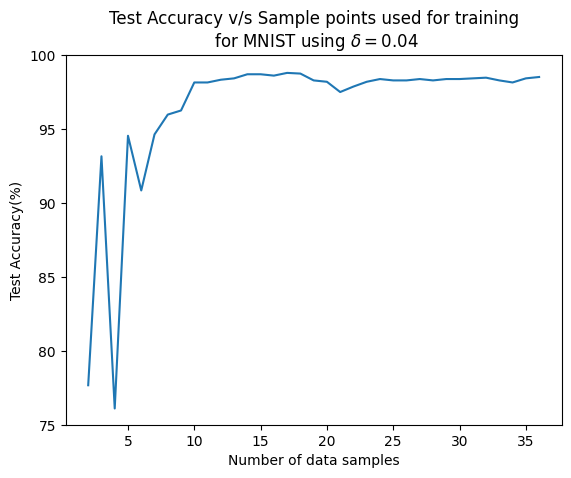

In [12]:
# Let's study the accuracy improvement for delta =0.04 with the number of samples being selected progressively
acc_i = []
lc_sample_selection = MyClassifier()
lc_sample_selection.delta = 0.04
uni = np.unique(S).tolist()
label_list = S.T.tolist()[0]
uni_ind = [label_list.index(uni[0]),label_list.index(uni[1])]
k = max(uni_ind)+1
lc_sample_selection.training_set_data = Y[uni_ind,:]
lc_sample_selection.training_set_labels = S[uni_ind,:]

lc_sample_selection.train(lc_sample_selection.training_set_data,lc_sample_selection.training_set_labels)
prev_num_queries = 0

for i in range(k,Y.shape[0]):
    prev_num_queries = lc_sample_selection.num_queries
    lc_sample_selection.sample_selection(Y[i,:],S[i])
    if(lc_sample_selection.num_queries > prev_num_queries):
        lc_sample_selection.training_set_labels = lc_sample_selection.training_set_labels.reshape(lc_sample_selection.training_set_labels.shape[0],1)
        lc_sample_selection.train(lc_sample_selection.training_set_data,lc_sample_selection.training_set_labels)
        acc_i.append(lc_sample_selection.accuracy(Y_test, S_test))
plt.title('Test Accuracy v/s Sample points used for training\n for MNIST using $\delta=0.04$')
plt.xlabel('Number of data samples')
plt.ylabel('Test Accuracy(%)')
plt.ylim([75,100])
plt.plot([i+2 for i in range(len(acc_i))],np.array(acc_i)*100)
plt.show()

# These values are not a firm representative of the graph in the report since we have uploaded the one in report after shuffling the dataset to present it in a generic sense.

In [13]:
# Now let's have a look at the results for test accuracy using randomly sampling from the dataset.
def rand_run(a_val):
    lc_rand = MyClassifier()
    ind = [i for i in range(S.shape[0])]
    ind_sel = sample(ind,a_val)
    lc_rand.training_set_data = Y[ind_sel,:]
    lc_rand.training_set_labels = S[ind_sel,:]
    lc_rand.train(lc_rand.training_set_data,lc_rand.training_set_labels)
    return (lc_rand.accuracy(Y_test, S_test))
acc_rand = []
samp_points = []
for i in range(3,300):
    try:
        temp=rand_run(i)
        acc_rand.append(temp)
        samp_points.append(i)
    except:
        pass 
    

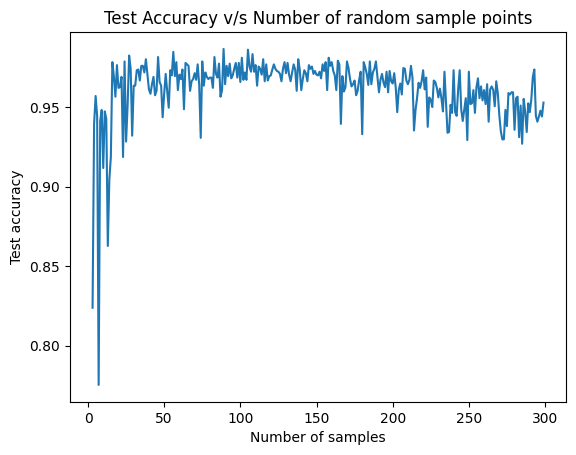

In [14]:
plt.plot(samp_points,acc_rand)
plt.title('Test Accuracy v/s Number of random sample points')
plt.xlabel('Number of samples')
plt.ylabel('Test accuracy')
plt.show()

## Part 1 - Gaussian data

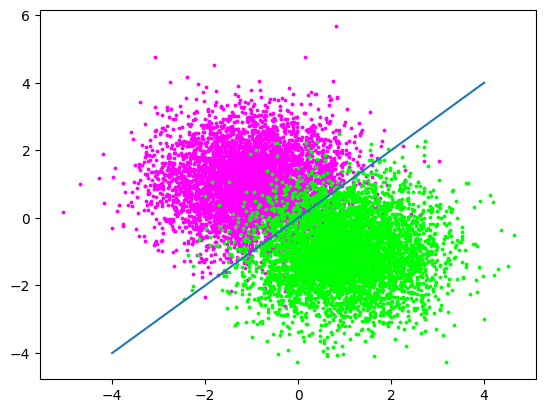

In [15]:
#Gaussian Data Set
mean_one = [-1, 1]
mean_two = [1,-1]
cov = [[1, 0], [0, 1]]
class_1_train = np.random.multivariate_normal(mean_one, cov, 5000)
class_2_train = np.random.multivariate_normal(mean_two, cov, 5000)
gauss_traindata = np.array(np.vstack([class_1_train,class_2_train])).T
gauss_trainlabels = np.array(np.hstack([[1]*5000, [-1]*5000]))
class_1_test = np.random.multivariate_normal(mean_one, cov, 1000)
class_2_test = np.random.multivariate_normal(mean_two, cov, 1000)
gauss_testdata = np.array(np.vstack([class_1_test,class_2_test]))
gauss_testlabels = np.array(np.hstack([[1]*1000, [-1]*1000]))
gauss_traindata = gauss_traindata.T
gauss_traindata = (gauss_traindata-np.min(gauss_traindata))/(np.max(gauss_traindata)-np.min(gauss_traindata))
# Training on the full Data set
lc = MyClassifier()
lc.train(gauss_traindata,gauss_trainlabels)

fig, ax = plt.subplots()
ax.scatter(class_1_train[:,0], class_1_train[:,1], c='magenta',s=3)
ax.scatter(class_2_train[:,0], class_2_train[:,1], c='lime',s=3)
x1 = np.linspace(-4,4)
y = [(-1*lc.biases[0] - lc.weights[0]*x1[i])/lc.weights[1] for i in range(x1.shape[0])]
ax.plot(x1,y)
plt.show()

In [16]:
# Training on the entire Gaussian dataset (No selective sampling) 
print('Test accuracy after training on {} points is '.format(lc.num_queries)+str(lc.accuracy(gauss_testdata,gauss_testlabels)))

Test accuracy after training on 10000 points is 0.913


In [17]:
# Now let's have a look at the accuracy scores using selective sampling while training
acc_vals_g = []
samp_ind_g = []
lc_gauss = MyClassifier()
uni = np.unique(gauss_trainlabels).tolist()
label_list = gauss_trainlabels.T.tolist()
uni_ind = [label_list.index(uni[0]),label_list.index(uni[1])]
k = max(uni_ind)+1
gauss_trainlabels = gauss_trainlabels.reshape(-1,1)
lc_gauss.training_set_data = gauss_traindata[uni_ind,:]
lc_gauss.training_set_labels = gauss_trainlabels[uni_ind,:]

lc_gauss.train(lc_gauss.training_set_data, lc_gauss.training_set_labels)
prev_num_queries = 0

for i in range(k,gauss_traindata.shape[0]):
    prev_num_queries = lc_gauss.num_queries
    lc_gauss.sample_selection(gauss_traindata[i,:].T,gauss_trainlabels[i])
    if(lc_gauss.num_queries > prev_num_queries):
      lc_gauss.training_set_labels = lc_gauss.training_set_labels.reshape(lc_gauss.training_set_labels.shape[0],1)
      lc_gauss.train(lc_gauss.training_set_data,lc_gauss.training_set_labels)
      acc_vals_g.append(lc_gauss.accuracy(gauss_testdata, gauss_testlabels))
      samp_ind_g.append(lc_gauss.num_queries)

# This prints the classification accuracy achieved after sample selection

acc_sample_selection =lc_gauss.accuracy(gauss_testdata, gauss_testlabels)
print('Test accuracy after training on {} points is '.format(lc_gauss.num_queries)+str(acc_sample_selection))

Test accuracy after training on 5 points is 0.8355


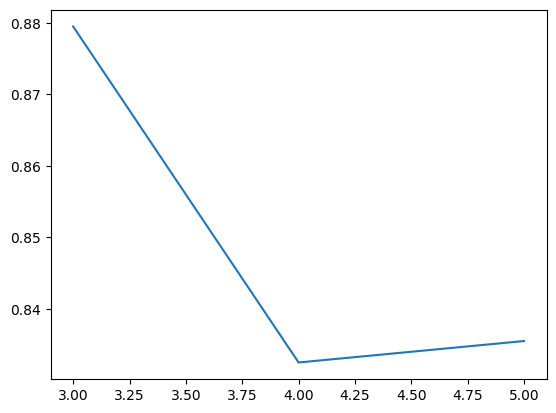

In [18]:
plt.plot(samp_ind_g,acc_vals_g)
plt.show()

# These values are not a firm representative of the graph in the report since we have uploaded the one in report after shuffling the dataset to present it in a generic sense.

## Part 2 - MNIST data

In [19]:
# Outperforms all data accuracy when we select 9000 points, achieving 99.8% accuracy
lc_ilp = MyClassifier()
lc_ilp.ILP(Y,S,9000)
lc_ilp.train(lc_ilp.training_set_data,lc_ilp.training_set_labels)
acc_ilp=lc_ilp.accuracy(Y, S)
print("ILP Data Set")
print(acc_ilp)
print(lc_ilp.num_queries)

solving...
ILP Data Set
0.9978473129853156
8999


In [20]:
# num_points_list = [4, 6, 8, 10, 16, 20, 28, 34, 40, 46, 50, 60, 80, 100, 140, 160, 180, 200, 400, 600, 800, 1000, 1400, 2000]
Y_shuffle, S_shuffle = shuffle(Y, S, random_state=24)
num_points_list = [i for i in range(4,4000,100)]

mnist_result = pd.DataFrame(columns=['Accuracy','Number of Points'])
j=0
for num_points in num_points_list:
  lc_ilp = MyClassifier()
  lc_ilp.ILP(Y_shuffle,S_shuffle,num_points)
  lc_ilp.train(lc_ilp.training_set_data,lc_ilp.training_set_labels)
  acc_ilp = lc_ilp.accuracy(Y_shuffle, S_shuffle)
  mnist_result.loc[j] = [acc_ilp, lc_ilp.num_queries]
  j=j+1

solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...


In [21]:
mnist_result

,Accuracy,Number of Points
0,0.504190,3.0
1,0.761129,103.0
2,0.866841,203.0
3,0.776428,303.0
4,0.837472,403.0
5,0.853079,503.0
6,0.878373,603.0
7,0.892058,703.0
8,0.882832,803.0
9,0.909510,903.0


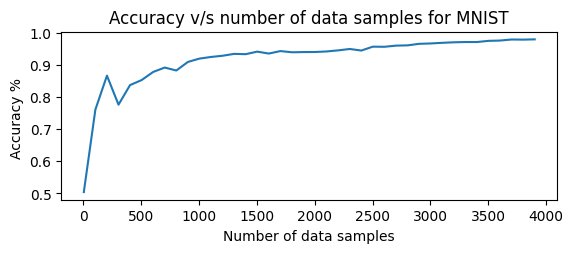

In [22]:
plt.subplot(2,1,1)
plt.plot(mnist_result['Number of Points'], mnist_result['Accuracy'])
plt.xlabel('Number of data samples')
plt.ylabel('Accuracy % ')
plt.title('Accuracy v/s number of data samples for MNIST')
plt.show()

## Part 2 - Gaussian data 

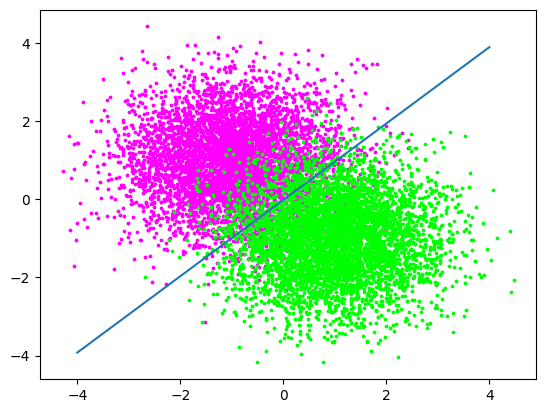

0.9255
10000


In [23]:
#Gaussian Data Set
mean_one = [-1, 1]
mean_two = [1,-1]
cov = [[1, 0], [0, 1]]
class_1_train = np.random.multivariate_normal(mean_one, cov, 5000)
class_2_train = np.random.multivariate_normal(mean_two, cov, 5000)
gauss_traindata = np.array(np.vstack([class_1_train,class_2_train])).T
gauss_trainlabels = np.array(np.hstack([[1]*5000, [-1]*5000]))
class_1_test = np.random.multivariate_normal(mean_one, cov, 1000)
class_2_test = np.random.multivariate_normal(mean_two, cov, 1000)
gauss_testdata = np.array(np.vstack([class_1_test,class_2_test]))
gauss_testlabels = np.array(np.hstack([[1]*1000, [-1]*1000]))

# Training on the full Data set
lc = MyClassifier()
lc.train(gauss_traindata.T,gauss_trainlabels)

fig, ax = plt.subplots()
ax.scatter(class_1_train[:,0], class_1_train[:,1], c='magenta',s=3)
ax.scatter(class_2_train[:,0], class_2_train[:,1], c='lime',s=3)
x1 = np.linspace(-4,4)
y = [(-1*lc.biases[0] - lc.weights[0]*x1[i])/lc.weights[1] for i in range(x1.shape[0])]
ax.plot(x1,y)
plt.show()
print(lc.accuracy(gauss_testdata,gauss_testlabels))
print(lc.num_queries)


solving...


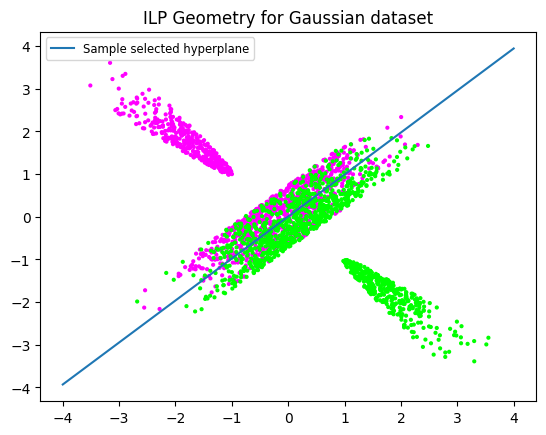

0.9265
2399


In [24]:
lc_ilp = MyClassifier()
lc_ilp.ILP(gauss_traindata.T,gauss_trainlabels,2400)
lc_ilp.train(lc_ilp.training_set_data,lc_ilp.training_set_labels)

fig, ax = plt.subplots()
ax.scatter(lc_ilp.training_set_data[:,0],lc_ilp.training_set_data[:,1], c=lc_ilp.training_set_labels,cmap=matplotlib.colors.ListedColormap(['lime','magenta']),s=4)
x1 = np.linspace(-4,4)
y = [(lc_ilp.biases[0] - lc_ilp.weights[0]*x1[i])/lc_ilp.weights[1] for i in range(x1.shape[0])]
ax.plot(x1,y, label='Sample selected hyperplane')
plt.title('ILP Geometry for Gaussian dataset')
ax.legend(loc='upper left',fontsize = 'small')
plt.show()
# fig.savefig('region_highlight.jpg', dpi=800)

print(lc_ilp.accuracy(gauss_testdata,gauss_testlabels))
print(lc_ilp.num_queries)

In [25]:
#num_points_list = [2, 4, 6, 8, 10, 16, 20, 28, 34, 40, 46, 50, 60, 80, 100, 140, 160, 180, 200]

num_points_list = [i for i in range(4, 50)]

shuffle_gauss_trainlabels, shuffle_gauss_traindata = shuffle(gauss_trainlabels, gauss_traindata.T, random_state=42)


gaussian_results = pd.DataFrame(columns=['Accuracy','Number of Points'])
j=0
for num_points in num_points_list:
  lc_ilp = MyClassifier()
  lc_ilp.ILP(shuffle_gauss_traindata,shuffle_gauss_trainlabels,num_points)
  lc_ilp.train(lc_ilp.training_set_data,lc_ilp.training_set_labels)
  gaussian_results.loc[j] = [lc_ilp.accuracy(gauss_testdata,gauss_testlabels), lc_ilp.num_queries]
  j=j+1

solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...


In [26]:
gaussian_results

,Accuracy,Number of Points
0,0.7755,3.0
1,0.7755,3.0
2,0.6770,5.0
3,0.6455,6.0
4,0.6425,7.0
5,0.6425,7.0
6,0.7845,9.0
7,0.9270,10.0
8,0.9270,11.0
9,0.9275,11.0


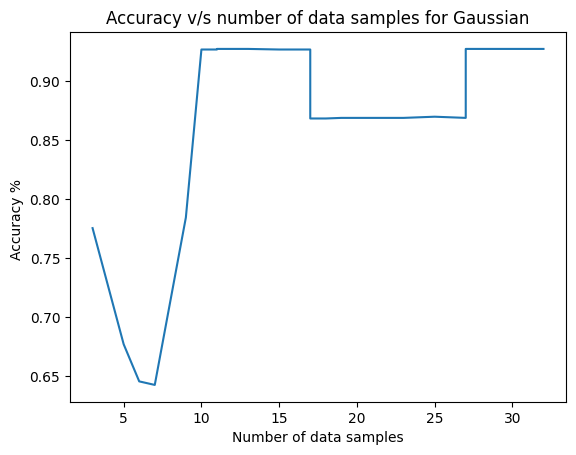

In [27]:
plt.plot(gaussian_results['Number of Points'][0:30], gaussian_results['Accuracy'][0:30])
plt.xlabel('Number of data samples')
plt.ylabel('Accuracy % ')
plt.title('Accuracy v/s number of data samples for Gaussian')
plt.show()

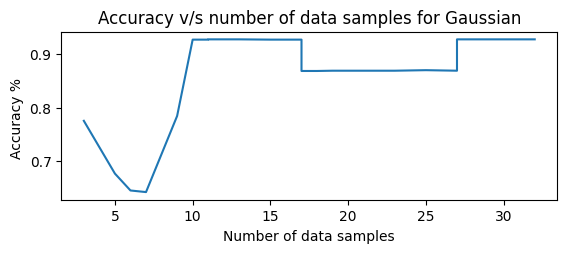

In [28]:
plt.subplot(2,1,2)
plt.plot(gaussian_results['Number of Points'][0:30], gaussian_results['Accuracy'][0:30])
plt.xlabel('Number of data samples')
plt.ylabel('Accuracy % ')
plt.title('Accuracy v/s number of data samples for Gaussian')
plt.show()

In [29]:
tune_list = [i for i in range(1,10)]

res = []

for tune in tune_list:
  lc_ilp = MyClassifier()
  lc_ilp.tune = tune
  lc_ilp.ILP(Y,S,28)
  lc_ilp.train(lc_ilp.training_set_data,lc_ilp.training_set_labels)
  acc_ilp = lc_ilp.accuracy(Y, S)
  res.append(acc_ilp)

solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...
solving...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


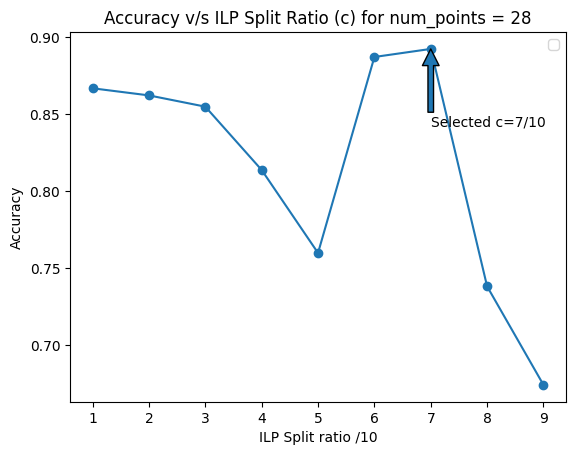

In [30]:
# print(res)
highlight = 7
plt.annotate('Selected c=7/10', xy=(highlight, res[highlight-1]),
             xycoords='data',
             xytext=(highlight, res[highlight-1]-0.05),
             textcoords='data',
             arrowprops=dict(lw=1)
           )
plt.plot(tune_list, res,'-o')
plt.title('Accuracy v/s ILP Split Ratio (c) for num_points = 28')
plt.xlabel('ILP Split ratio /10')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# plt.savefig('c_vs_accuracy.png', dpi=800)